In [2]:
# import os
# os.environ['KERAS_BACKEND'] = 'theano'

In [28]:
import os
import numpy as np
import tensorflow.keras as keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import PIL
import seaborn as sn
%matplotlib inline

<h4 style="font-family: Ubuntu; padding: 2%; font-size: 25px; font-weight: lighter;">Function to plot the images</h4>

In [1]:
def plots(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

<h4 style="padding: 2%; font-size: 25px; font-weight: lighter;font-family: Ubuntu">This node is only used to create the dummy dataset <span style="color: tomato; font-size: 18px;">(please ignore if present)</span></h4>

In [30]:
# req = {'train':100, 'test': 40, 'validate': 50}
# for i in ['train', 'test', 'validate']:
#     for j in ['angry', 'happy', 'surprise']:
# #         os.system('mkdir ../dummy_data/' + i + '/' + j)
#         files = os.listdir('../data/' + i + '/' + j)[:req[i]]

#         for file in files:
#             os.system('cp ../data/' + i + '/' + j + '/' + file +' ../dummy_data/' + i + '/' + j + '/' + file)
# #             print('cp ../data/' + i + '/' + j + '/' + file +' ../dummy_data/' + i + '/' + j + '/' + file)
# #             break

<h4 style="font-family: Ubuntu; padding: 2%; font-size: 25px; font-weight: lighter;">Setting train, test and validate paths</h4>

In [6]:
train_path = '../data/train'
test_path = '../data/test'
validate_path = '../data/validate'

In [2]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(48, 48), classes=['angry', 'happy', 'surprise'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(48, 48), classes=['angry', 'happy', 'surprise'], batch_size=8)
validate_batches = ImageDataGenerator().flow_from_directory(validate_path, target_size=(48, 48), classes=['angry', 'happy', 'surprise'], batch_size=10)

<h4 style="font-family: Ubuntu; padding: 2%; font-size: 25px; font-weight: lighter;">Having a look at the Images</h4>

In [3]:
imgs, labels = next(train_batches)

plots(imgs, rows=8)

<h4 style="font-family: Ubuntu; padding: 2%; font-size: 25px; font-weight: lighter;">Building the model</h4>

In [ ]:
num_features = 64
width = 48
height = 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 3)))
model.add(BatchNormalization())

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(num_features * 2, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(num_features * 4, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(num_features * 6, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(num_features * 6, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(num_features * 8, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_features * 4, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_features * 2, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

<h4 style="font-family: Ubuntu; padding: 2%; font-size: 25px; font-weight: lighter;">Training the model</h4>

In [ ]:
model.fit_generator(train_batches, steps_per_epoch=252, epochs=100, verbose=2, validation_data=validate_batches, validation_steps=126)

<h4 style="font-family: Ubuntu; padding: 2%; font-size: 25px; font-weight: lighter;">Testing the model</h4>

In [21]:
emotions = "angry, disgust, fear, happy, neutral, sad, surprise".split(", ")
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(48, 48), classes = emotions, batch_size=4037)

Found 4037 images belonging to 7 classes.


In [22]:
test_imgs, test_labels = next(test_batches)
test_labels = [emotions[np.where(i == 1)[0][0]] for i in test_labels]

In [23]:
correct = 0
predictions = []
for i,j in zip(test_imgs, test_labels):
    prediction = model.predict(np.expand_dims(i, axis=0))
    predicted_val = emotions[np.where(prediction == np.amax(prediction))[1][0]]
    # print("Predicted: {0} \t Actual: {1}".format(predicted_val, j))
    predictions.append(predicted_val)
    correct += 1 if predicted_val in j else 0
print("{0} / {1}".format(correct, len(test_labels)))

2559 / 4037


In [24]:
print("Test Accuracy: %.2f " % (correct / len(test_labels) * 100) + "%")

Test Accuracy: 63.39 %


<h4 style="font-family: Ubuntu; padding: 2%; font-size: 20px; font-weight: lighter;">Confusion Matrix</h4>

In [25]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

[[251  13  66  23  53  45  16]
 [ 53 383  23  10  10  25   0]
 [ 45   5 229  15  63  80  59]
 [ 21   2  30 711  76  24  31]
 [ 47   3  62  41 372  68  14]
 [ 77   9 124  31 122 270  20]
 [ 10   2  24  14  17   5 343]]


In [26]:
def map_plot(cm, cmap, name, width, height, fmt='g'):
    plt.subplots(figsize=(width, height))
    sn.heatmap(cm, annot=True, cmap=cmap, annot_kws={"size": 12}, fmt=fmt, xticklabels=emotions, yticklabels=emotions)
    plt.title(name, fontdict={'fontsize': '14', 'color': '#000000'})
    plt.xlabel("Predicted", fontdict={'fontsize': '14'})
    plt.ylabel("Actual", fontdict={'fontsize': '14'})
    plt.show()

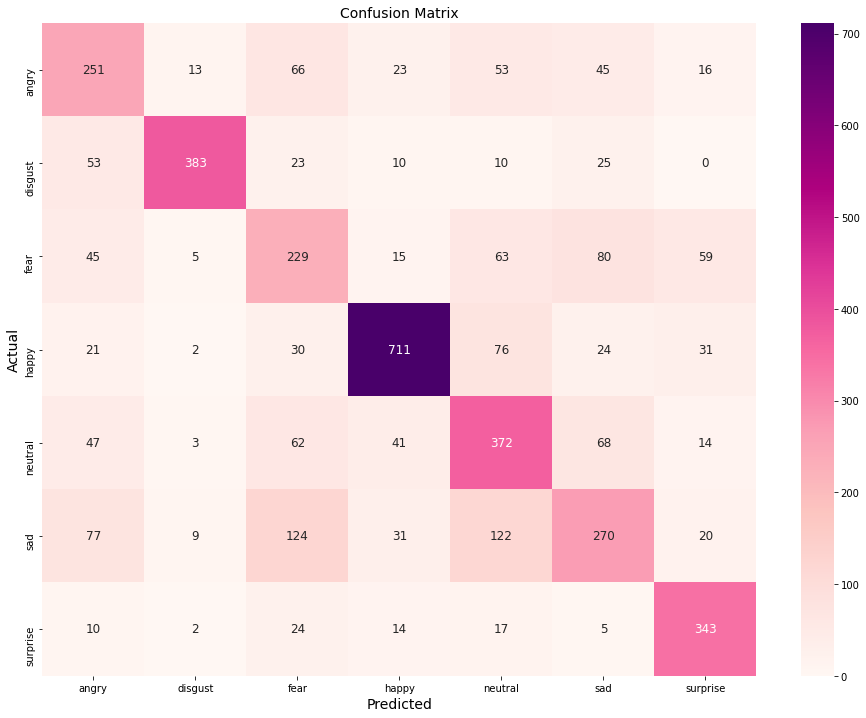

In [27]:
# cmaps = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink','spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']
# cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
# cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
# cmaps = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu','RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
# cmaps = ['twilight', 'twilight_shifted', 'hsv']
# cmaps = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']
# cmaps = ['flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

# for cmap in cmaps:
#     map_plot(cm, cmap, cmap, width=16, height=12)

map_plot(cm, 'RdPu', "Confusion Matrix", width=16, height=12)